In [81]:
#An IPython magic extension for printing date and time stamps, version numbers, and hardware information. 
#%load_ext watermark 
%watermark -a "Salim Chemlal" -n -t -v 
import warnings
warnings.filterwarnings('ignore')

Salim Chemlal Tue Sep 06 2016 11:49:10 

CPython 2.7.11
IPython 4.1.2


# Time Series

TS is a collection of data points collected at constant time intervals. These are analyzed to determine the long term trend so as to forecast the future or perform some other form of analysis. But what makes a TS different from a regular regression problem? There are 2 things:

1. It is time dependent. So the basic assumption of a linear regression model that the observations are independent doesn’t hold in this case.
2. Along with an increasing or decreasing trend, most TS have some form of seasonality trends, i.e. variations specific to a particular time frame. 

## 1. Load Data

In [82]:
from __future__ import division
from datetime import date
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal as sp_signal
from sklearn import ensemble
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

plt.style.use('fivethirtyeight')

_DATA_DIR = r'C:\Users\engadmin\Desktop\Diabetes  Project Code\Input\input'
_FIG_DIR = r'C:\Users\engadmin\Desktop\Diabetes  Project Code\figures'

if not os.path.exists(_FIG_DIR):
    os.makedirs(_FIG_DIR)

_GULCOSE_DATA_PATH = os.path.join(_DATA_DIR, 'P1.csv')
_BEGINNING_DATE = date(2008, 6, 30)

## Matplotlib Variables
_FIG_SIZE = (16, 12)
_FIG_FORMAT = 'png'
_FIG_DPI = 200
_FIG_LEGEND_LOCATION = 4

_ORIGINAL_SIGNAL_LABEL = 'Original Signal'
_MEAN_AVERAGE_SIGNAL_LABEL = 'Mean Averaged Signal'
_MEDIAN_FILTERED_SIGNAL_LABEL = 'Median Filtered Signal'
_EXPONENTIAL_SMOOTHED_AVERAGE_SIGNAL_LABEL = 'Exponential Moving Averaged Signal'
_SNP_CYCLE_SIGNAL_LABEL = 'Cycle Signal'
_SNP_TREND_SIGNAL_LABEL = 'Trend'
_BAND_PASS_FILTER_LABEL = 'Band-pas filtered'

_BUTTERWORTH_FILTER_TITLE = 'Butterworth filter frequency response'
_BUTTERWORTH_FILTER_XLABEL = 'Frequency [radians / second]'
_BUTTERWORTH_FILTER_YLABEL = 'Amplitude [dB]'

_MEAN_AVERAGE_SIGNAL_TITLE_TEMPLATE = 'Mean Average signal with window = {}'.format
_MEDIAN_FILTER_SIGNAL_TITLE_TEMPLATE = 'Median Filtered signal with window = {}'.format
_EXPONENTIAL_SMOOTHING_TITLE_TEMPLATE = 'Exponential Smoothed signal with span = {}'.format
_BAND_PASS_TITLE_TEMPLATE = 'Band-pass order: {}, low - high cutoff frequency: {} - {}'.format
_HODRICK_PRESSCOTT_TITLE_TEMPLATE = 'Trend and Cycle Signal with smoothing parameter: {}'.format

def _file_format(string_):
    string_ = string_.replace('-', '_').replace(' ', '_').replace('$', '')
    string_ += '.' + _FIG_FORMAT
    return string_

### Data Explanation
- Gluocse reading taken every 5 mins


                 Date  Time Minutes  mg/dL CHO (g) Fat (g) Protein (g)  \
1 2008-06-30 18:18:00           0.0  113.0     NaN     NaN         NaN   
2 2008-06-30 18:23:00           5.0  113.0     NaN     NaN         NaN   
3 2008-06-30 18:28:00          10.0  111.0     NaN     NaN         NaN   
4 2008-06-30 18:33:00          15.0  110.0     NaN     NaN         NaN   
5 2008-06-30 18:38:00          20.0  110.0     NaN     NaN         NaN   

  Transverse accel - peaks Heat flux - average Longitudinal accel - average  \
1                      269         69.76335907                  0.382614881   
2                      238         97.71972656                  0.956527054   
3                       79         152.7075195                  0.682047307   
4                      305         107.7606888                  0.357662201   
5                      305         38.94045258                  0.411726385   

  Near-body temp - average Transverse accel - MAD GSR - average  \
1            

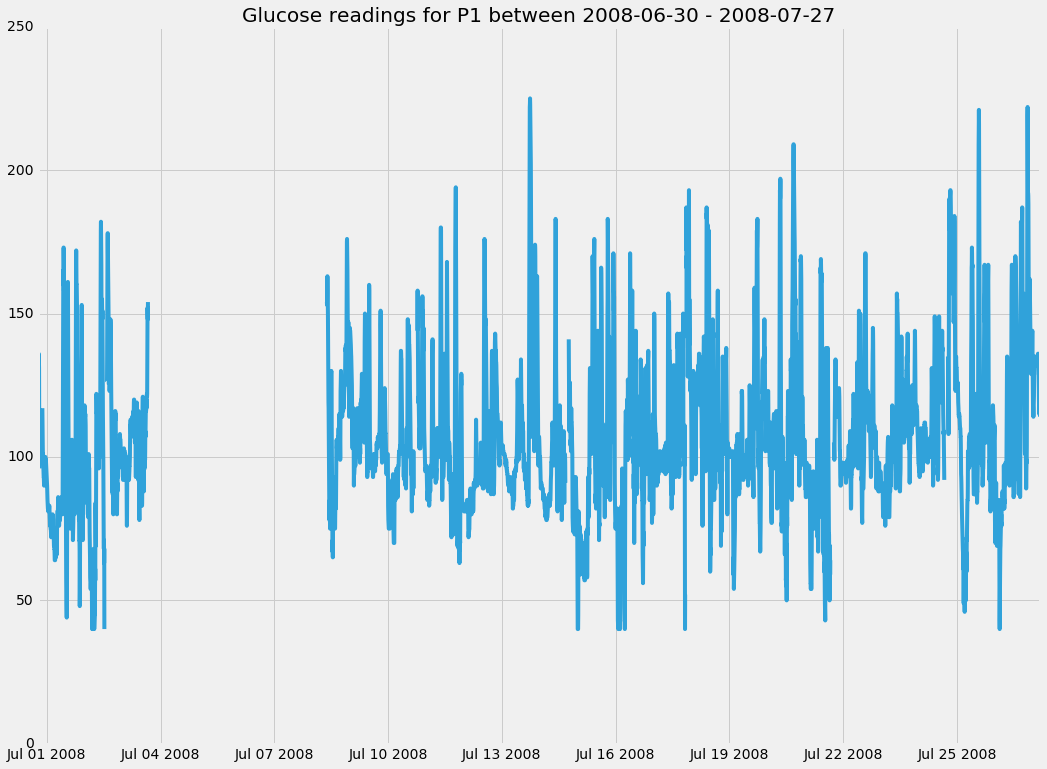

In [85]:
df = pd.read_csv(_GULCOSE_DATA_PATH, parse_dates=['Date']) #read and prase Date col as dataTimes object
df = df.sort(['Date'])
df = df[df.Date > _BEGINNING_DATE]
print df.head()
print '\n Data Types:'
print df.dtypes

title = 'Glucose readings for P1 between {} - 2008-07-27'.format(_BEGINNING_DATE)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df['mg/dL'], '-');
plt.title(title);
plt.savefig(fig_path, dpi=_FIG_DPI)


Remove the first data before: 2008-07-18
data size: 36316


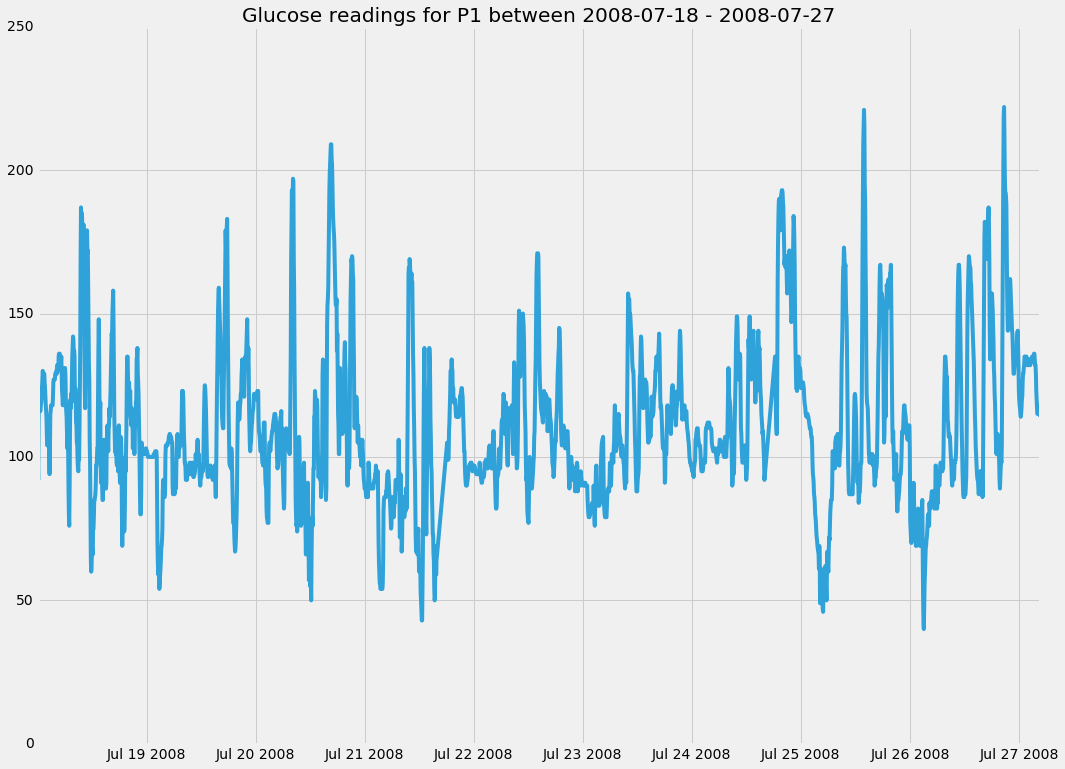

In [89]:
_START_DATE = date(2008,7,18)
print "Remove the first data before:", _START_DATE 
df = df[df.Date > _START_DATE]
title = 'Glucose readings for P1 between {} - 2008-07-27'.format(_START_DATE)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df['mg/dL'], '-');
plt.title(title);
plt.savefig(fig_path, dpi=_FIG_DPI)
print "data size:", df.size

Remove NaN
data size: 36316


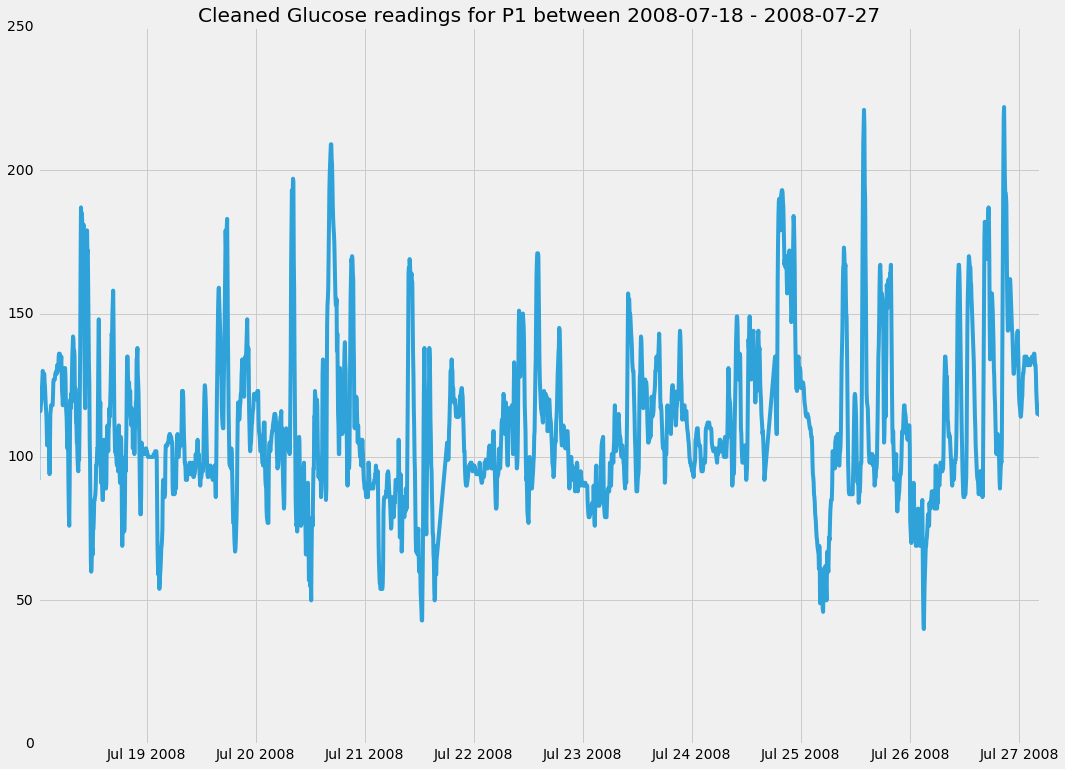

In [87]:
#Remove 'NAN' Values 
df = df[np.isfinite(df['mg/dL'])]
print "Remove NaN"
''
title = 'Cleaned Glucose readings for P1 between {} - 2008-07-27'.format(_START_DATE)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df['mg/dL'], '-');
plt.title(title);
plt.savefig(fig_path, dpi=_FIG_DPI)

print "data size:", df.size

## 2. Check Stationarity of a Time Series?

A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. But why is it important? Most of the TS models work on the assumption that the TS is stationary. Intuitively, we can sat that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future. Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

1. constant mean
2. constant variance
3. an autocovariance that does not depend on time.



### Plotting Rolling Statistics: 

We can plot the moving average or moving variance and see if it varies with time. This is more of a visual technique.




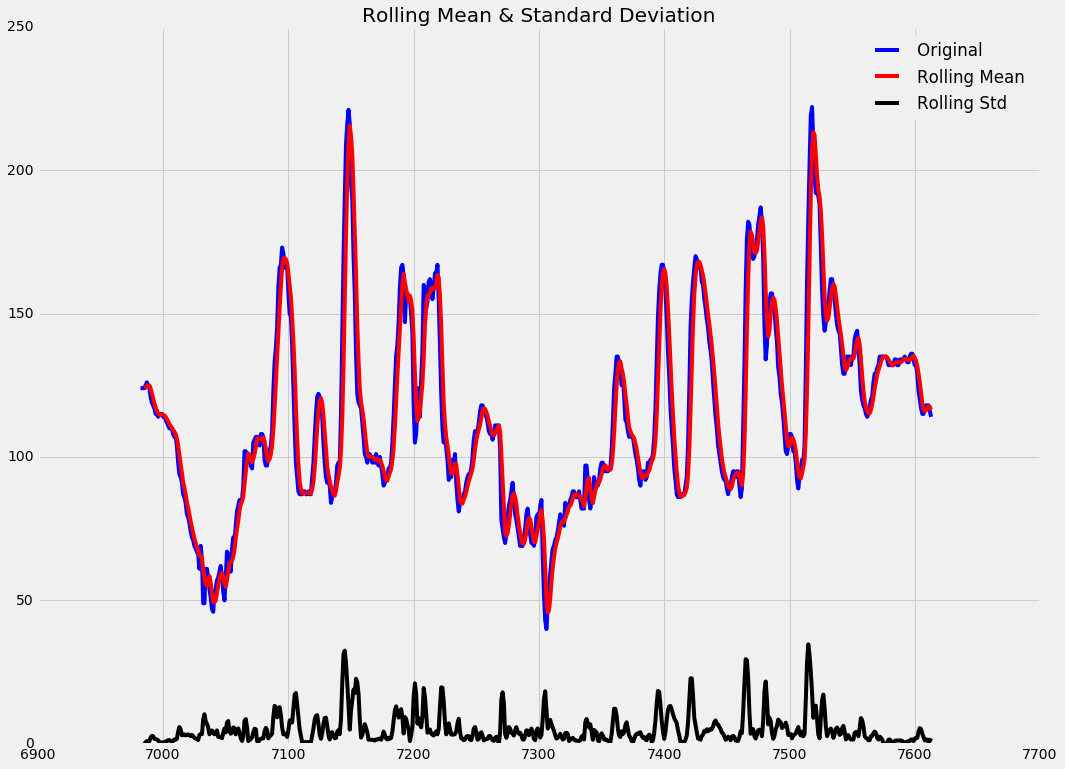

In [53]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=4)
    rolstd = pd.rolling_std(timeseries, window=4)

    #Plot rolling statistics:
    plt.figure(figsize=_FIG_SIZE)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)



test_stationarity(df['mg/dL'])



### Dickey-Fuller Test: 
This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

In [54]:
#Perform Dickey-Fuller test:
def test_stationarity_DickeyFuller(timeseries):
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    t_value_test  = dftest[0] < dfoutput['Critical Value (5%)']
    p_value_test =  dftest[1] < 0.05
    print '\n 95% confidence:'
    print "Is the Test Statistic(", dftest[0],")less than the Critical Value(5%) (",dfoutput['Critical Value (5%)'], "):",t_value_test
    print "Is the p-value (", dftest[1],")less than the 0.05:", p_value_test
    print"Then..."
    if (p_value_test):
       print "we reject the null hypothesis and say series is stationary series, since the test statistic < critical values and p-value < 0.05"  
    else: 
        print "Cannot say series is stationary series, since the test statistic > critical values and p-value > 0.05"                                                                                  

test_stationarity_DickeyFuller(df['mg/dL'])




Results of Dickey-Fuller Test:
Test Statistic                  -5.600814
p-value                          0.000001
#Lags Used                       1.000000
Number of Observations Used    630.000000
Critical Value (5%)             -2.866139
Critical Value (1%)             -3.440772
Critical Value (10%)            -2.569219
dtype: float64

 95% confidence:
Is the Test Statistic( -5.60081397803 )less than the Critical Value(5%) ( -2.86613860558 ): True
Is the p-value ( 1.26604651311e-06 )less than the 0.05: True
Then...
we reject the null hypothesis and say series is stationary series, since the test statistic < critical values and p-value < 0.05


## 3. Trend estimation


Trend estimation is a family of methods to be able to detect and predict tendencies and regularities in time series signals without knowing any information a priori about the signal. Trend estimation is not only useful for trends but also could yield seasonality(cycles) of data as well. 

There can be many ways of doing this and some of most commonly used are:

- Aggregation – taking average for a time period like monthly/weekly averages
- Smoothing – taking rolling averages
- Polynomial Fitting – fit a regression model


We will discuss smoothing here. Smoothing refers to taking rolling estimates, i.e. considering the past few instances. 


## Smoothing algorithms:

There are can be various ways but we will discuss the following: 

1. Moving average filtering
2. Exponential Weighted Moving Average (EWMA)
3. Median filtering
4. Bandpass filtering
5. Hodrick-Prescott Filter


### 3.1. Moving Average Filtering

For a window size: $N$, Applying window on top of the original signal and average the signal for a given time window. Following formula assumes that $N$ being odd.

$$y(t) = \frac{\displaystyle\sum_{i=-\frac{N+1}{2}}^{\frac{N+1}{2}} x(t + i)}{w} $$

- Linear
- Not really a trend estimation method, but provides baseline
- If the window size is small, it removes high volatility part in the signal
- If the window size is large, it exposes the long-term trend
- Not robust to outliers and abrupt changes for small and medium window sizes

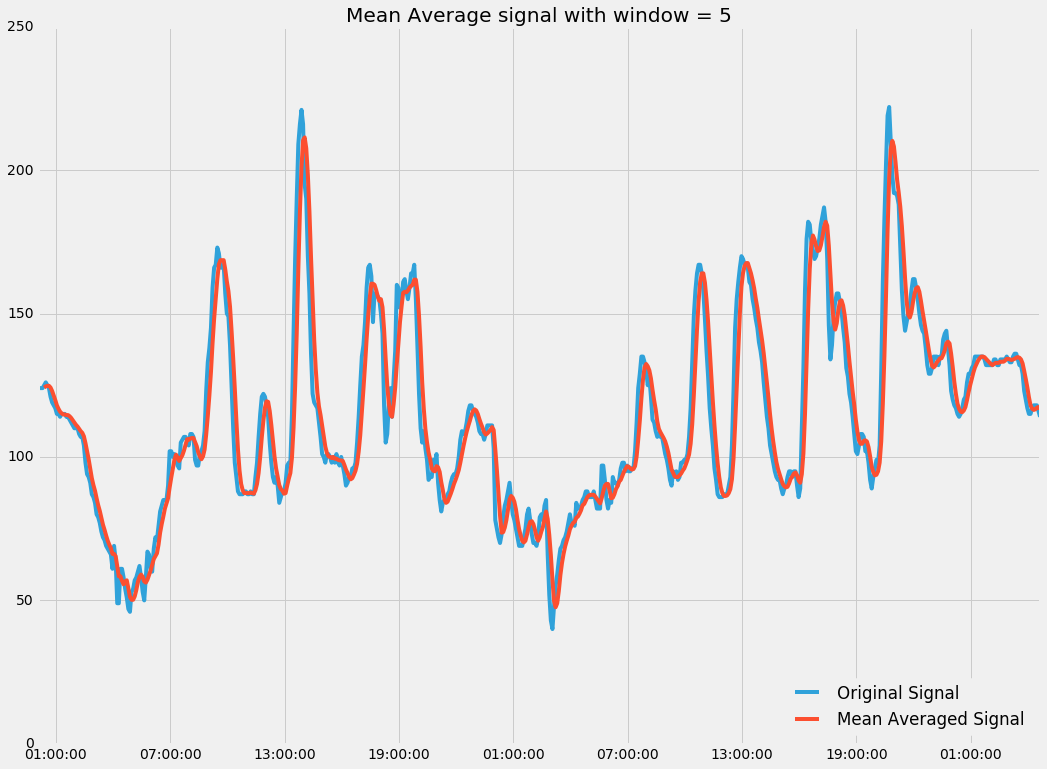

In [65]:
window = 5
title = _MEAN_AVERAGE_SIGNAL_TITLE_TEMPLATE(window)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df['mg/dL'], '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, pd.rolling_mean(df['mg/dL'], window), '-', label=_MEAN_AVERAGE_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

### Test stationarity

 Test stationarity for : Mean Average signal with window = 4


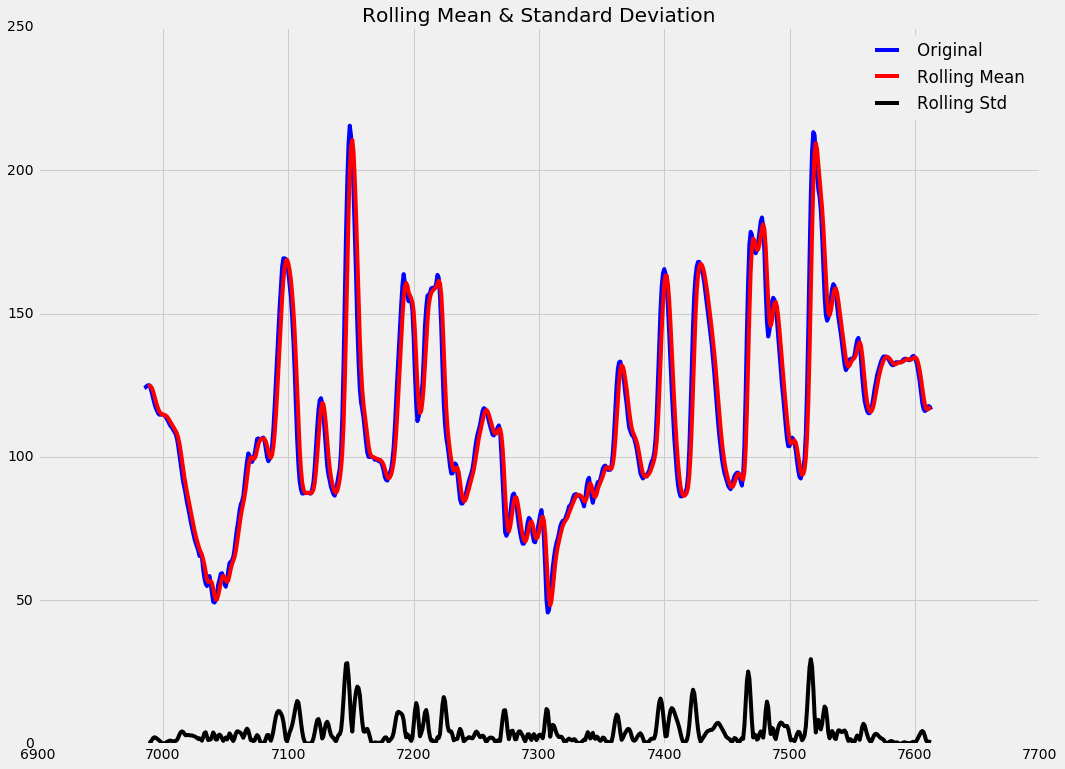

Results of Dickey-Fuller Test:
Test Statistic                  -3.346991
p-value                          0.012904
#Lags Used                      19.000000
Number of Observations Used    609.000000
Critical Value (5%)             -2.866298
Critical Value (1%)             -3.441133
Critical Value (10%)            -2.569304
dtype: float64

 95% confidence:
Is the Test Statistic( -3.3469911724 )less than the Critical Value(5%) ( -2.86629757035 ): True
Is the p-value ( 0.0129042596223 )less than the 0.05: True
Then...
we reject the null hypothesis and say series is stationary series, since the test statistic < critical values and p-value < 0.05


In [60]:
print" Test stationarity for :" , title
ts_log_moving_avg_diff= pd.rolling_mean(df['mg/dL'], window)
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)
test_stationarity_DickeyFuller(ts_log_moving_avg_diff)

### 3.2. Median Filter
Median Filter is very similar to the moving average filter. It only differs from computation of median of a given window rather than computing a mean.

$$ y(t) = median( x[t-\frac{w}{2}, t+\frac{w}{2}])$$

where $w$ is the window size whose median will replace the original data point

- Nonlinear
- Very robust to noise
- If the window size is very large, it could _shadow_ mid-term change
- Trend signal may not be smooth(actually rarely is in practice)

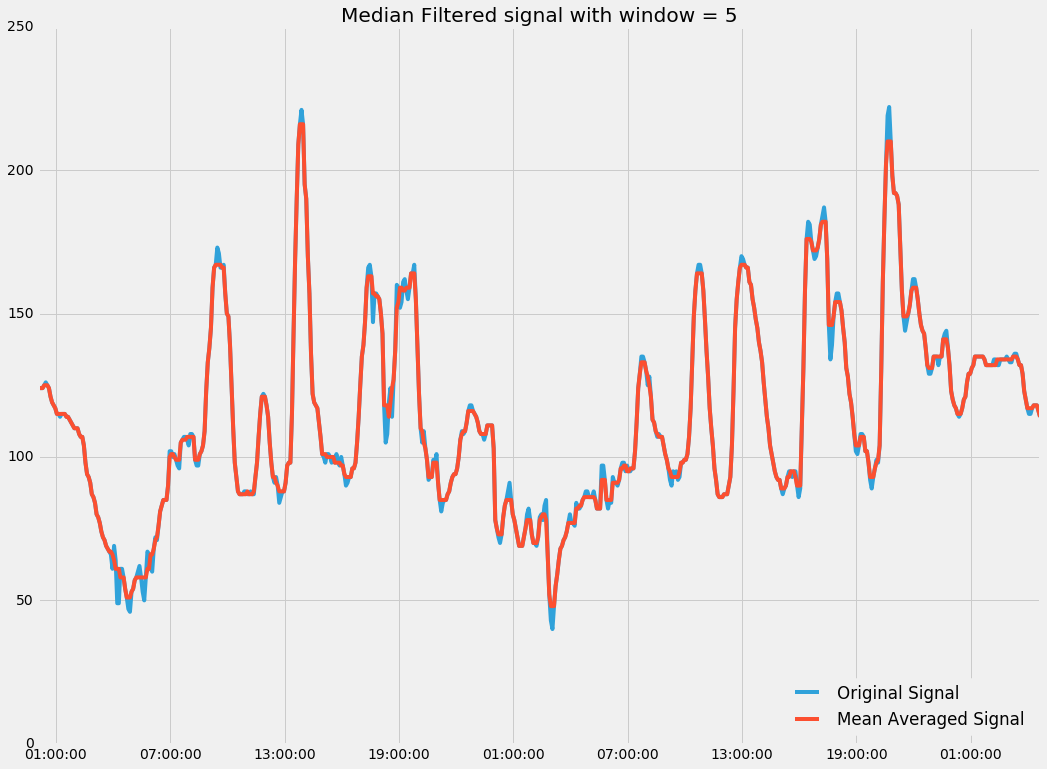

In [63]:
window = 5
median_filtered_signal = sp_signal.medfilt(df['mg/dL'], window)
title = _MEDIAN_FILTER_SIGNAL_TITLE_TEMPLATE(window)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df['mg/dL'], '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, median_filtered_signal, '-', label=_MEAN_AVERAGE_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

### Test stationarity


 Test stationarity for : Mean Average signal with window = 5


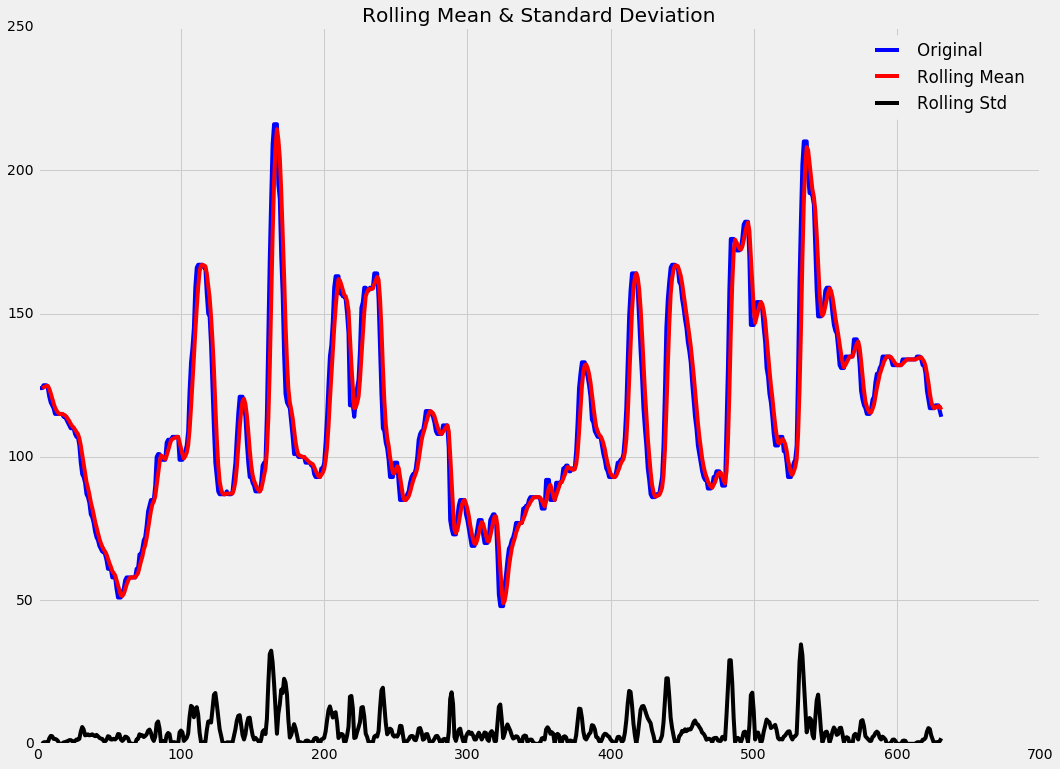

Results of Dickey-Fuller Test:
Test Statistic                -5.759099e+00
p-value                        5.727560e-07
#Lags Used                     1.000000e+00
Number of Observations Used    6.300000e+02
Critical Value (5%)           -2.866139e+00
Critical Value (1%)           -3.440772e+00
Critical Value (10%)          -2.569219e+00
dtype: float64

 95% confidence:
Is the Test Statistic( -5.75909885651 )less than the Critical Value(5%) ( -2.86613860558 ): True
Is the p-value ( 5.72756023895e-07 )less than the 0.05: True
Then...
we reject the null hypothesis and say series is stationary series, since the test statistic < critical values and p-value < 0.05


In [66]:
print" Test stationarity for :" , title

test_stationarity(median_filtered_signal)
test_stationarity_DickeyFuller(median_filtered_signal)

## 3. Exponential Weighted Moving Average (EWMA)

$$ y_t = \frac{\displaystyle\sum_i^t w_i x_{t-i}}{\displaystyle\sum_i^t w_i} $$

$$ w_i = \left\{
     \begin{array}{lr}
       \alpha (1 - \alpha)^i & i \lt t\\
       (1 - \alpha)^i & i = t
     \end{array}
   \right.
$$


$$ \alpha = \left\{
     \begin{array}{lr}
       \frac{2}{s+1} & \text{s=span}\\
       \frac{1}{c+1} & \text{c=center of mass}\\
       (1 - e^{\frac{log 0.5}{h}}) & \text{h = half life}
     \end{array}
   \right.
$$

One can think the exponential weights in terms of span and half life. Half life signifies when the weight becomes half of the max and span is how many days it spans when you get the average of signal with weights.


- Linear
- Could provide a better estimate than a simple moving average because the weights
are better distributed
- Not robust to outliers and abrupt changes
- Very flexible in terms of weights and puts more emphasis on the spatial window
in the signal

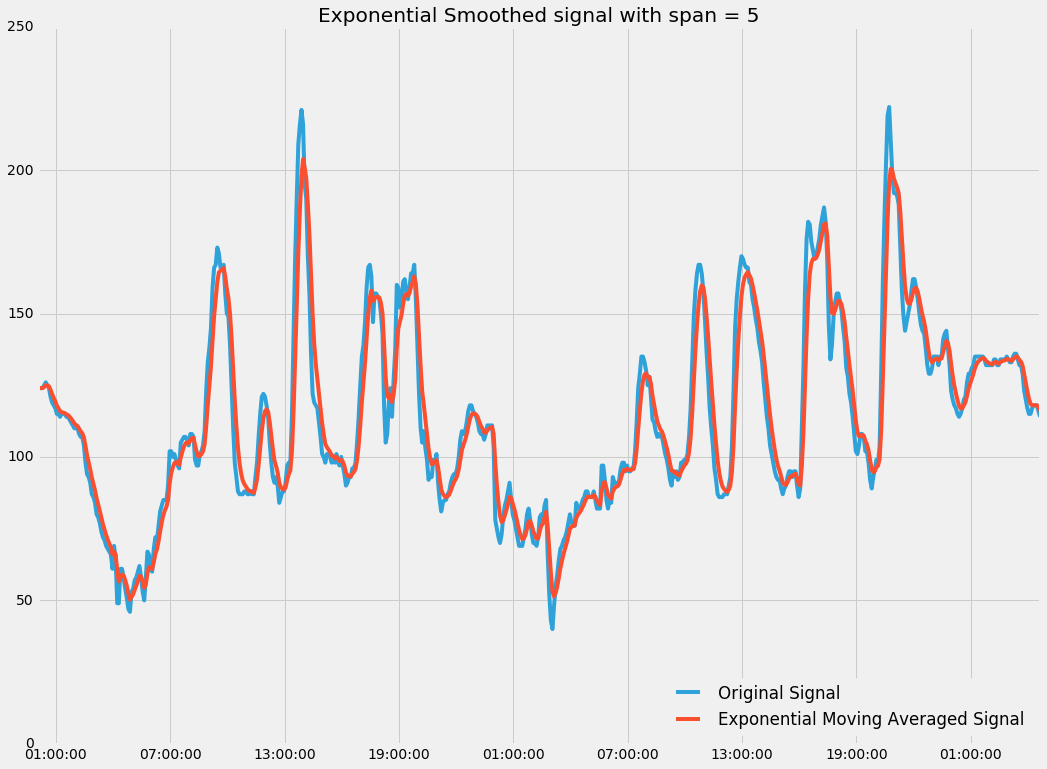

In [67]:
## Exponential Weighted Moving Average
span = 5
title = _EXPONENTIAL_SMOOTHING_TITLE_TEMPLATE(span)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df['mg/dL'], '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, pd.stats.moments.ewma(df['mg/dL'], span=span), '-', label=_EXPONENTIAL_SMOOTHED_AVERAGE_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

### Test stationarity

 Test stationarity for : Exponential Smoothed signal with span = 21


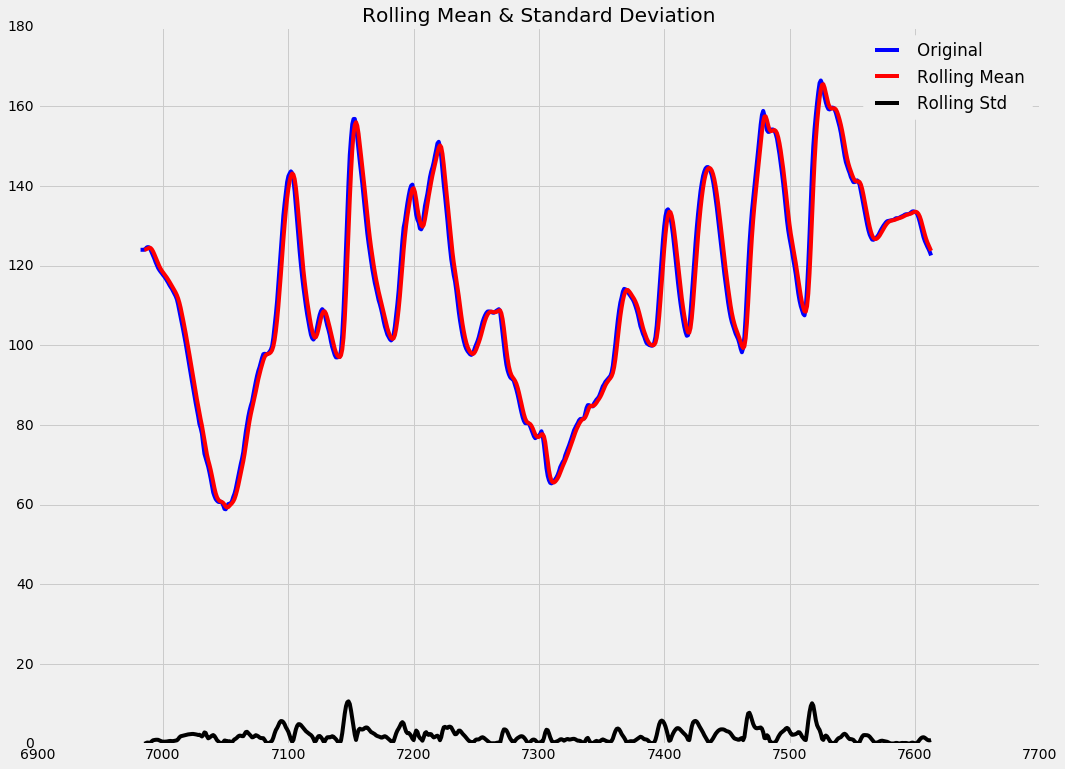

Results of Dickey-Fuller Test:
Test Statistic                  -3.069577
p-value                          0.028888
#Lags Used                       5.000000
Number of Observations Used    626.000000
Critical Value (5%)             -2.866168
Critical Value (1%)             -3.440839
Critical Value (10%)            -2.569235
dtype: float64

 95% confidence:
Is the Test Statistic( -3.06957693738 )less than the Critical Value(5%) ( -2.86616806031 ): True
Is the p-value ( 0.0288880981549 )less than the 0.05: True
Then...
we reject the null hypothesis and say series is stationary series, since the test statistic < critical values and p-value < 0.05


In [69]:
print" Test stationarity for :" , title
ts_log_moving_avg_diff= pd.stats.moments.ewma(df['mg/dL'], span=span)
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)
test_stationarity_DickeyFuller(ts_log_moving_avg_diff)

## 4. Bandpass Filtering
Bandpass filters allow certain frequencies of the signal(between `low cutoff frequency` and `high cutoff frequency`) and attenuates the other frequencies. By doing so, one can prepare different bandpass filters to stop a particular band as well(called band-stop filter). If the signal is very volatile(high frequency) and you want to also remove the bias(low frequency), then bandpass filter provides a nice sweet spot to remove/attenuate low frequency and high frequency in the signal. 

- Allow certain frequencies of the signal(between `low cutoff frequency` and `high cutoff frequency`) and attenuates the other frequencies.
- This provides a flexible way to remove/attenuate low frequency(very long term) and high frequency(short-term) in the signal.
- Could prepare different filters to stop a particular band as well(called band-stop filter).


#### **[TODO]** :  redo this part ?

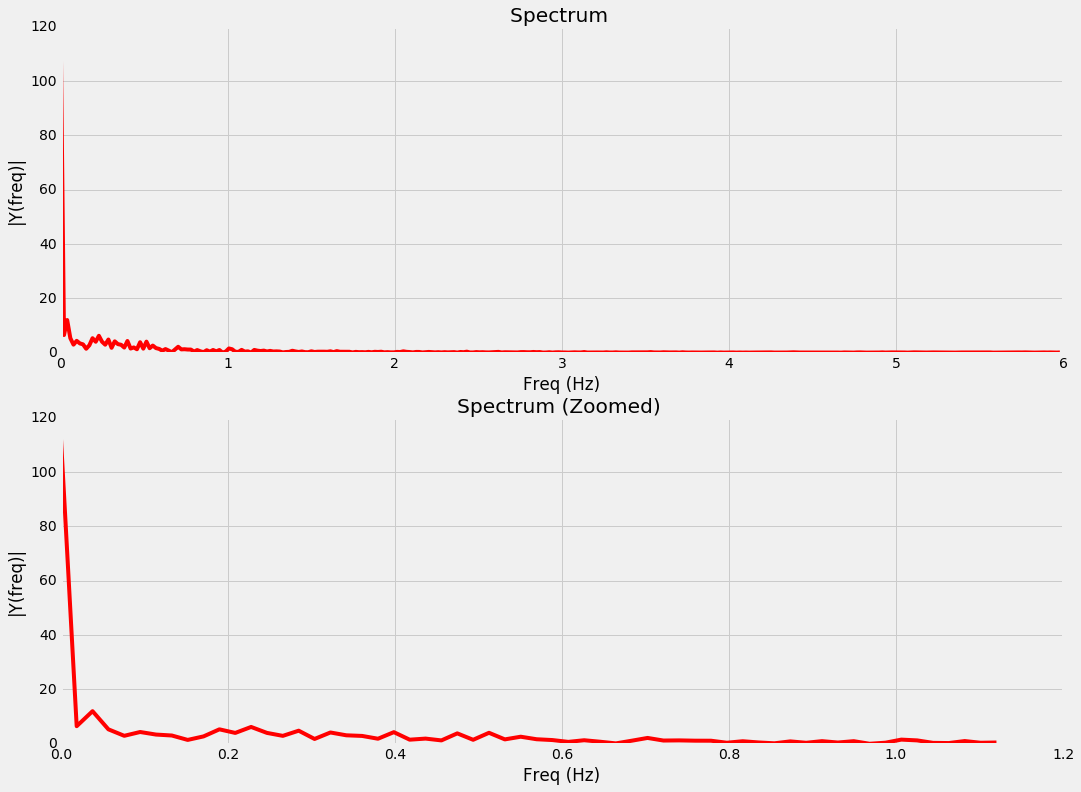

In [70]:
y = df['mg/dL'][np.isfinite(df['mg/dL'])]
n = len(y.values) # length of the signal
Fs = 12;  # sampling rate/ hour ( every 5 min)
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,1,n) # time vector


T = n/Fs
k = np.arange(n)
frq = k/T # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range

Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(int(n/2))]


plt.figure(figsize=_FIG_SIZE)
plt.subplot(2, 1, 1)
plt.plot(frq,abs(Y),'r') # plotting the spectrum
plt.xlabel('Freq (Hz)')
plt.ylabel('|Y(freq)|')
plt.title('Spectrum ')

plt.subplot(2, 1, 2)
plt.plot(frq[0:60],abs(Y[0:60]),'r') # plotting the spectrum
plt.xlabel('Freq (Hz)')
plt.ylabel('|Y(freq)|')
plt.title('Spectrum (Zoomed) ')

#### **[TODO]** : We need to find optimal low and high cutoffs

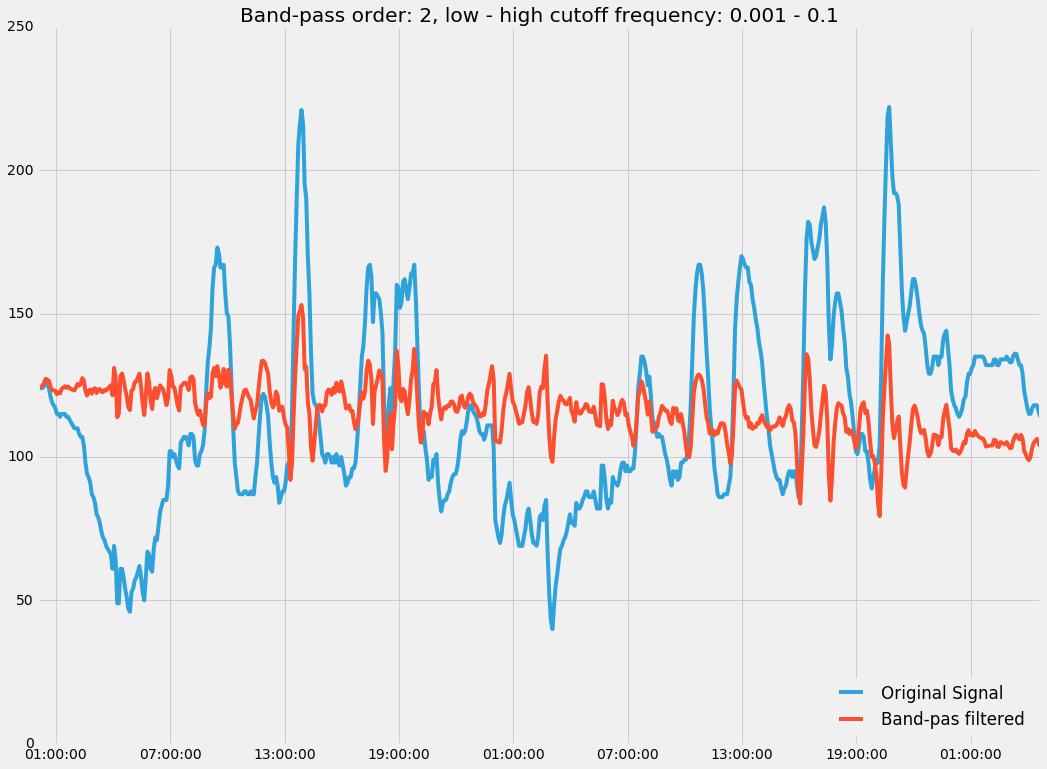

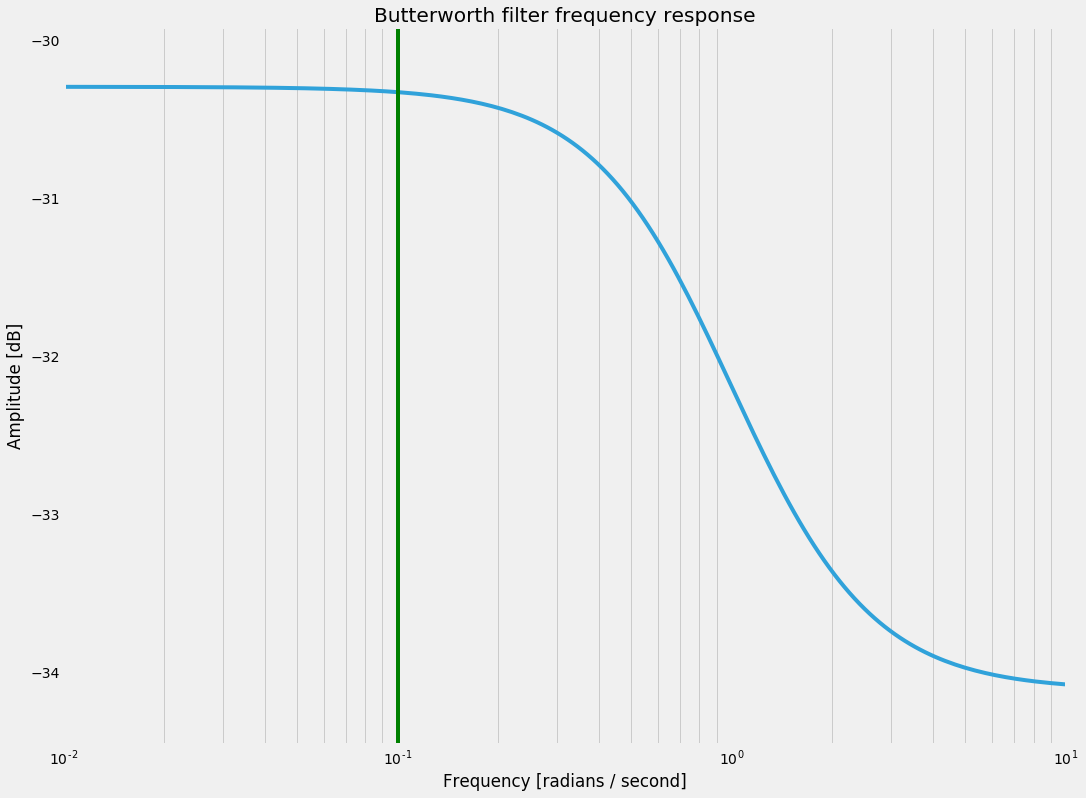

In [71]:
## Filter Construction
filter_order  = 2
low_cutoff_frequency = 0.001
high_cutoff_frequency = 0.10
b, a = sp_signal.butter(filter_order, [low_cutoff_frequency, high_cutoff_frequency], btype='bandpass', output='ba')
bandpass_filtered = sp_signal.filtfilt(b, a, df['mg/dL'].values)

# Notewe are removing this bandpass filters

# Plot
title = _BAND_PASS_TITLE_TEMPLATE(filter_order, low_cutoff_frequency, high_cutoff_frequency)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df['mg/dL'], '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, df['mg/dL']-bandpass_filtered, '-', label=_BAND_PASS_FILTER_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
#plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)


w, h = sp_signal.freqs(b, a)
plt.figure(figsize=_FIG_SIZE)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title(_BUTTERWORTH_FILTER_TITLE)
plt.xlabel(_BUTTERWORTH_FILTER_XLABEL)
plt.ylabel(_BUTTERWORTH_FILTER_YLABEL)
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(0, color='green')
plt.axvline(high_cutoff_frequency, color='green');

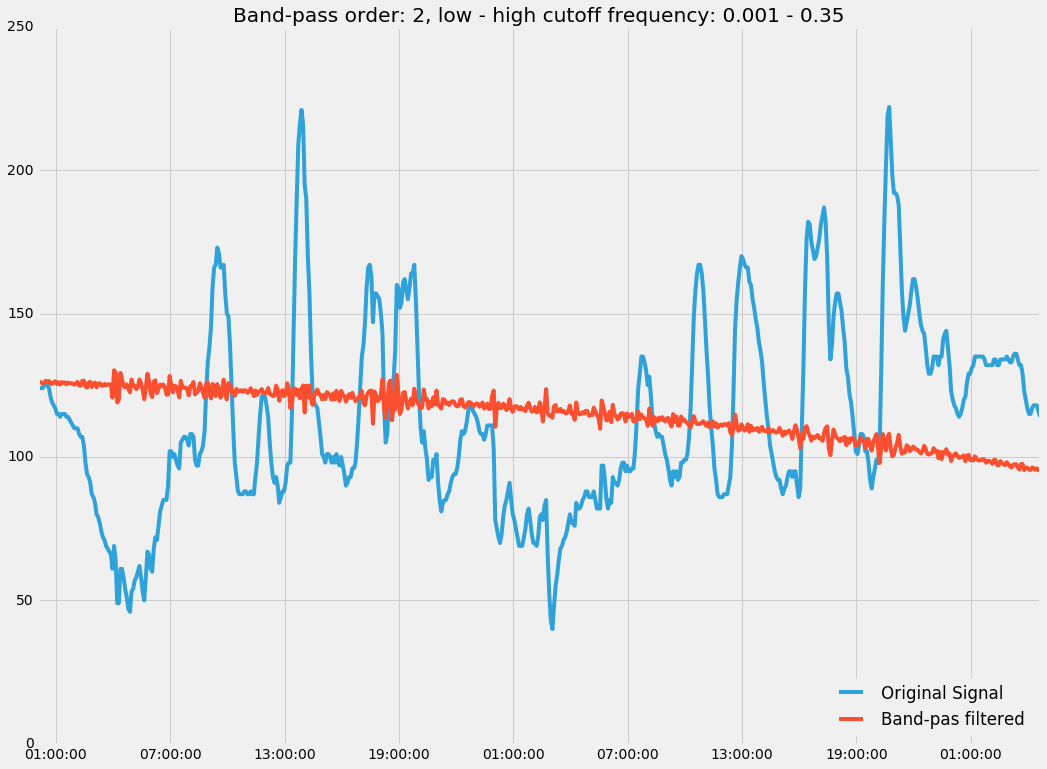

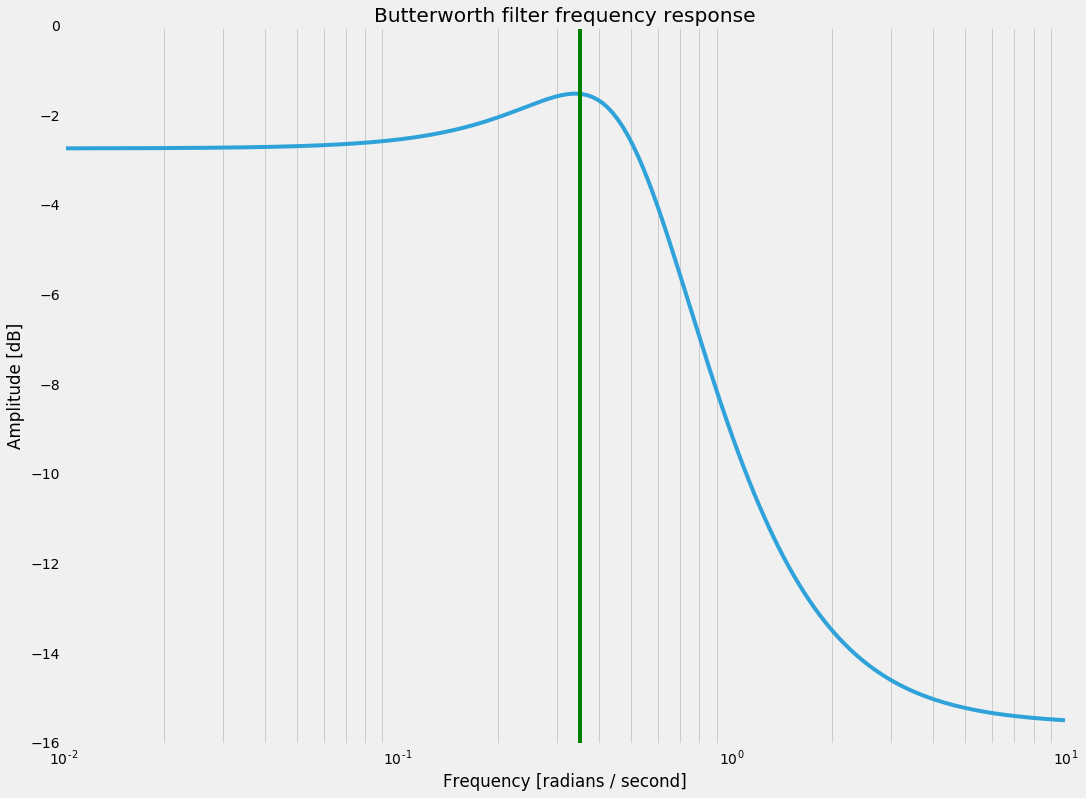

In [72]:
## Filter Construction
filter_order  = 2
low_cutoff_frequency = 0.001
high_cutoff_frequency = 0.35
b, a = sp_signal.butter(filter_order, [low_cutoff_frequency, high_cutoff_frequency], btype='bandpass', output='ba')
bandpass_filtered = sp_signal.filtfilt(b, a, df['mg/dL'].values)

# Plot
title = _BAND_PASS_TITLE_TEMPLATE(filter_order, low_cutoff_frequency, high_cutoff_frequency)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df['mg/dL'], '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, df['mg/dL']-bandpass_filtered, '-', label=_BAND_PASS_FILTER_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
#plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)


w, h = sp_signal.freqs(b, a)
plt.figure(figsize=_FIG_SIZE)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title(_BUTTERWORTH_FILTER_TITLE)
plt.xlabel(_BUTTERWORTH_FILTER_XLABEL)
plt.ylabel(_BUTTERWORTH_FILTER_YLABEL)
#plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(0, color='green')
plt.axvline(high_cutoff_frequency, color='green');

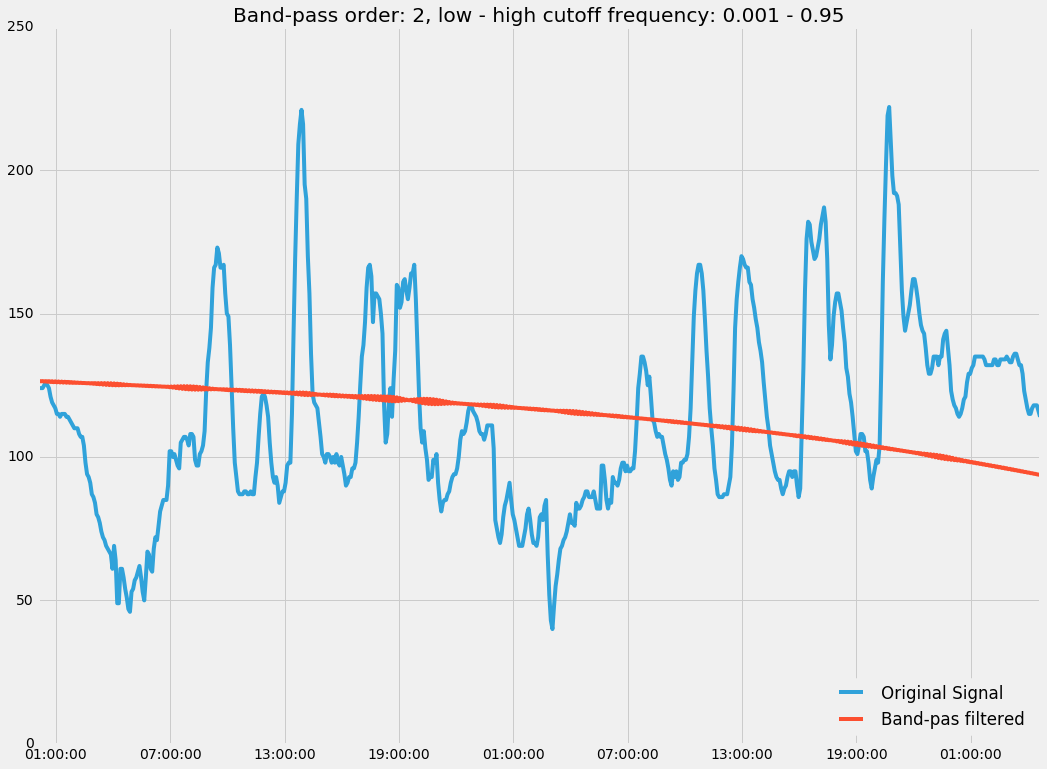

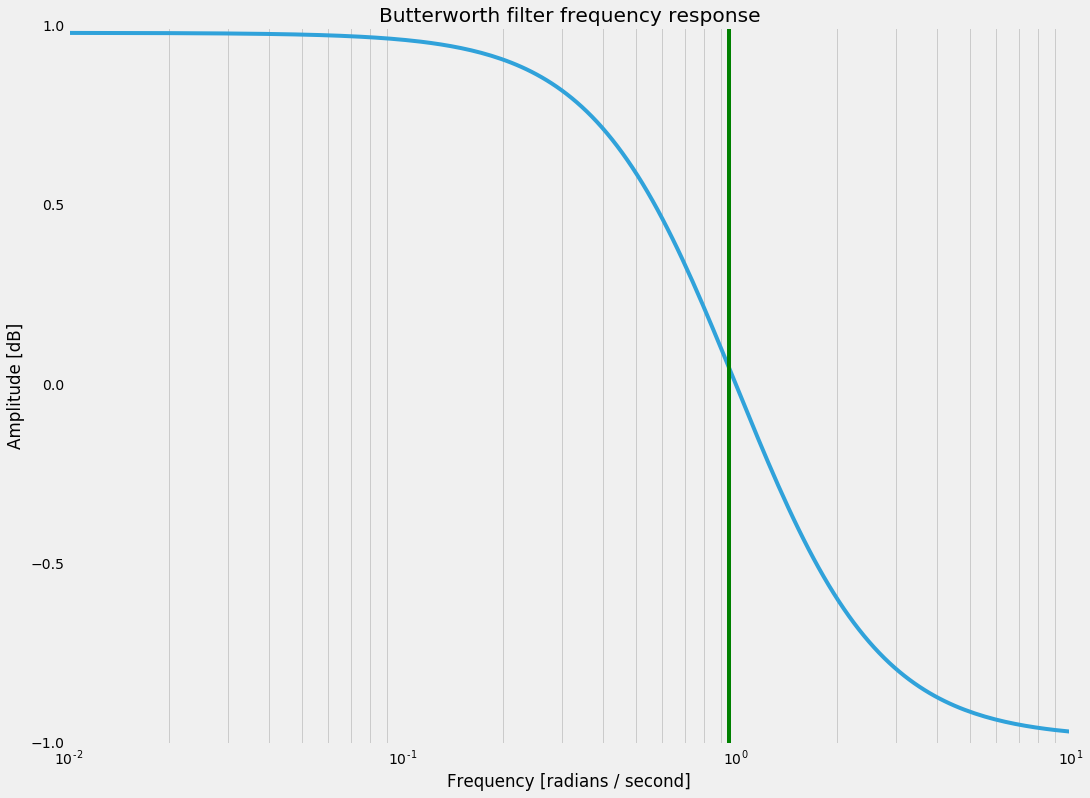

In [73]:
## Filter Construction
filter_order  = 2
low_cutoff_frequency = 0.001
high_cutoff_frequency = 0.95
b, a = sp_signal.butter(filter_order, [low_cutoff_frequency, high_cutoff_frequency], btype='bandpass', output='ba')
bandpass_filtered = sp_signal.filtfilt(b, a, df['mg/dL'].values)

# Plot
title = _BAND_PASS_TITLE_TEMPLATE(filter_order, low_cutoff_frequency, high_cutoff_frequency)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df['mg/dL'], '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, df['mg/dL']-bandpass_filtered, '-', label=_BAND_PASS_FILTER_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
#plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)


w, h = sp_signal.freqs(b, a)
plt.figure(figsize=_FIG_SIZE)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title(_BUTTERWORTH_FILTER_TITLE)
plt.xlabel(_BUTTERWORTH_FILTER_XLABEL)
plt.ylabel(_BUTTERWORTH_FILTER_YLABEL)
#plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(0, color='green')
plt.axvline(high_cutoff_frequency, color='green');

### Test stationarity

 Test stationarity for : Band-pass order: 2, low - high cutoff frequency: 0.001 - 0.95


C:\Users\engadmin\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\engadmin\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


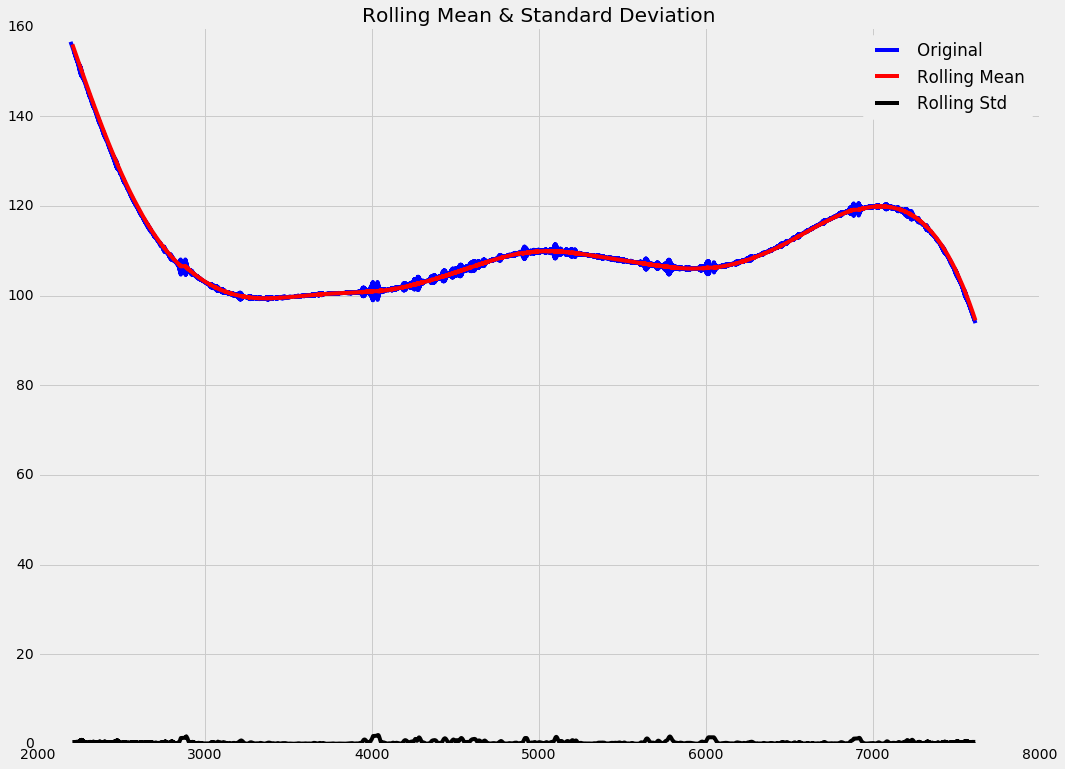

Results of Dickey-Fuller Test:
Test Statistic                -8.821462e+00
p-value                        1.872355e-14
#Lags Used                     3.300000e+01
Number of Observations Used    5.260000e+03
Critical Value (5%)           -2.862090e+00
Critical Value (1%)           -3.431594e+00
Critical Value (10%)          -2.567063e+00
dtype: float64

 95% confidence:
Is the Test Statistic( -8.82146216409 )less than the Critical Value(5%) ( -2.86208964 ): True
Is the p-value ( 1.8723546534e-14 )less than the 0.05: True
Then...
we reject the null hypothesis and say series is stationary series, since the test statistic < critical values and p-value < 0.05


In [28]:
print" Test stationarity for :" , title

test_stationarity(df['mg/dL']-bandpass_filtered)
test_stationarity_DickeyFuller(df['mg/dL']-bandpass_filtered)

### 3.4 Hodrick-Prescott Filter
 you could decompose the signal into two compoenent; one cycle part(which is short-term) and one trend part(which is medium-to-long term), which is what Hodrick-Prescott Filter tries to do.

Hodrick Prescott filter is a bandpass filter where it tries to decompose the time-series signal into a trend $x_t$ (mid-term growth) and a cylical component(recurring and seasonal signal) $c_t$.  

$$y_t = x_t + c_t$$

The loss function that it tries to minimize is the following:

$$\min_{\\{ x_{t}\\} }\sum_{t}^{T} c_{t}^{2}+\lambda\displaystyle\sum_{t=1}^{T}\left[\left(x_{t}- x_{t-1}\right)-\left(x_{t-1}-x_{t-2}\right)\right]^{2}$$

The first term is the square of difference of original signal and growth signal(cylical component) and $\lambda$ is the smoothing parameter. 

Based on the smoothing parameter, you could actually change what type of effects you may want to include or capture(if you want to capture some variation and volatility in short-term signal, then you may want to use a smaller smoothing parameter so that you have less smooth signal. If you want to also capture only a long term range signal, the smoothing parameter could be chosen arbitrarily large. However, in order to get some changes, we need to not to choose very large smoothing optimization parameter. 

**Charaterstics:**

- Linear
- Decomposes the signal into two distinct components(trend and cycle)
- Cycle part => short term, season
- Trend part => medium to long term
- With changing regularizer, smoothing can be adjusted in the signal
- Bandpass filter is at its heart
- Perfect for signals that show seasonality
- Yields good results when noise is normally distributed


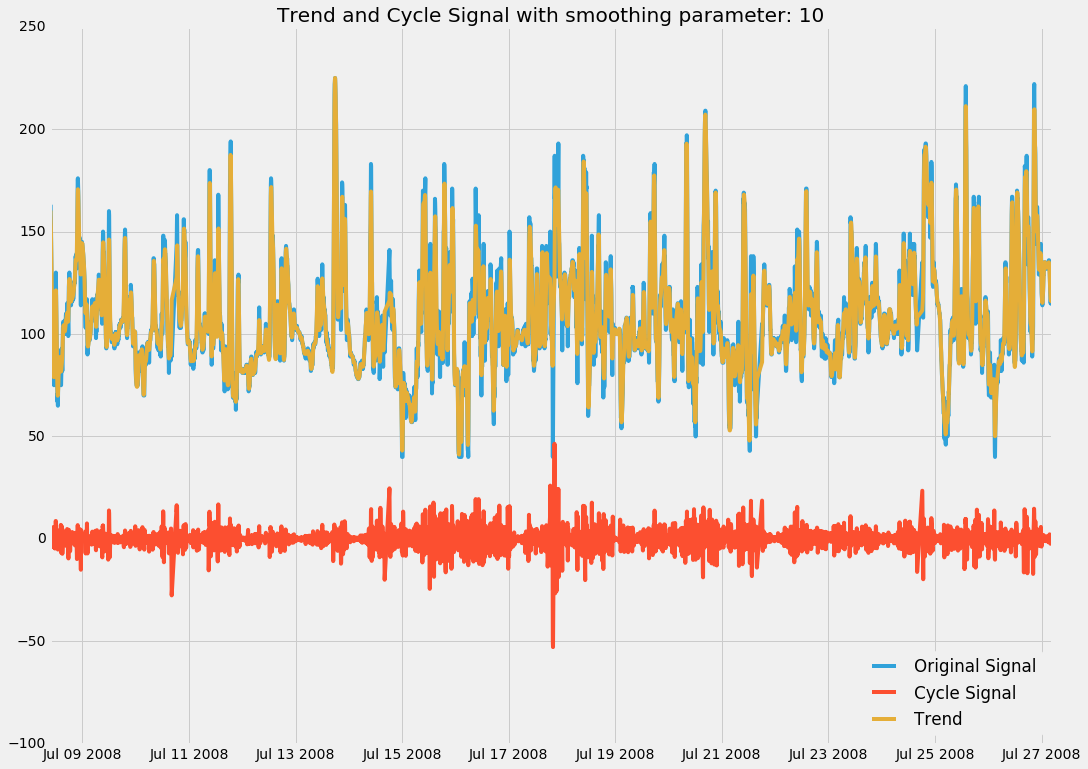

In [29]:
lamb = 10
snp_cycle, snp_trend = sm.tsa.filters.hpfilter(df['mg/dL'], lamb=lamb)
title = _HODRICK_PRESSCOTT_TITLE_TEMPLATE(lamb)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df['mg/dL'], '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, snp_cycle, '-', label=_SNP_CYCLE_SIGNAL_LABEL)
plt.plot_date(df.Date, snp_trend, '-', label=_SNP_TREND_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

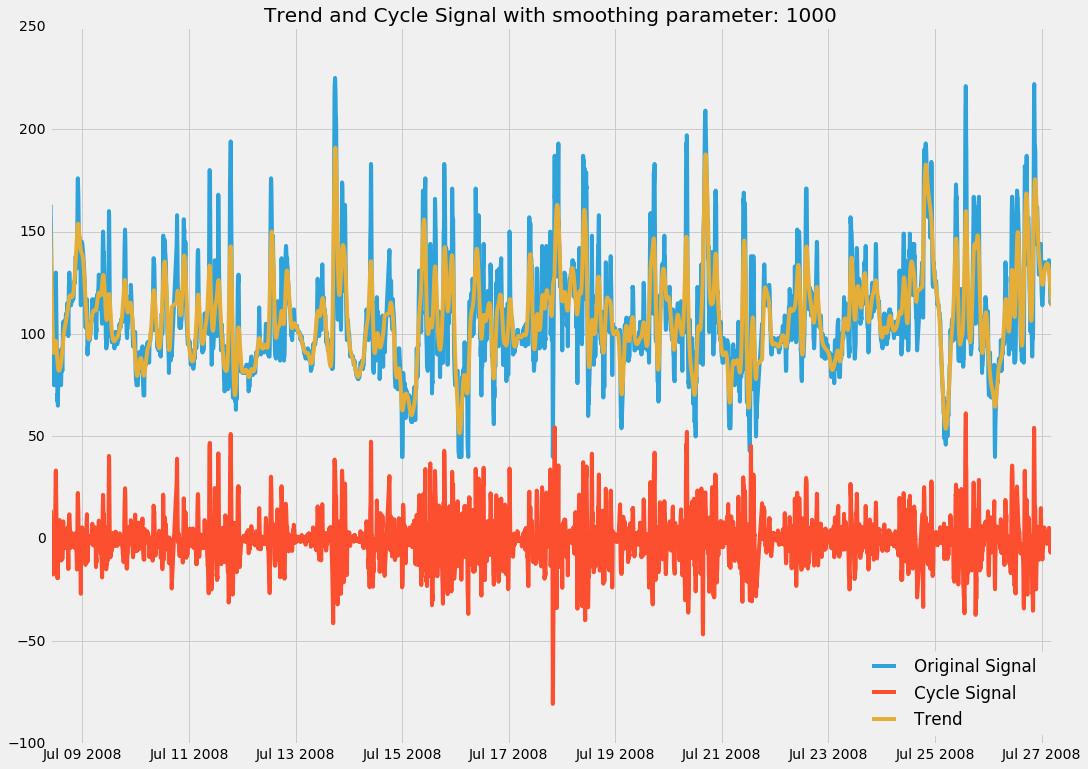

In [30]:
lamb = int(1e3)
snp_cycle, snp_trend = sm.tsa.filters.hpfilter(df['mg/dL'], lamb=lamb)
title = _HODRICK_PRESSCOTT_TITLE_TEMPLATE(lamb)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df['mg/dL'], '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, snp_cycle, '-', label=_SNP_CYCLE_SIGNAL_LABEL)
plt.plot_date(df.Date, snp_trend, '-', label=_SNP_TREND_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

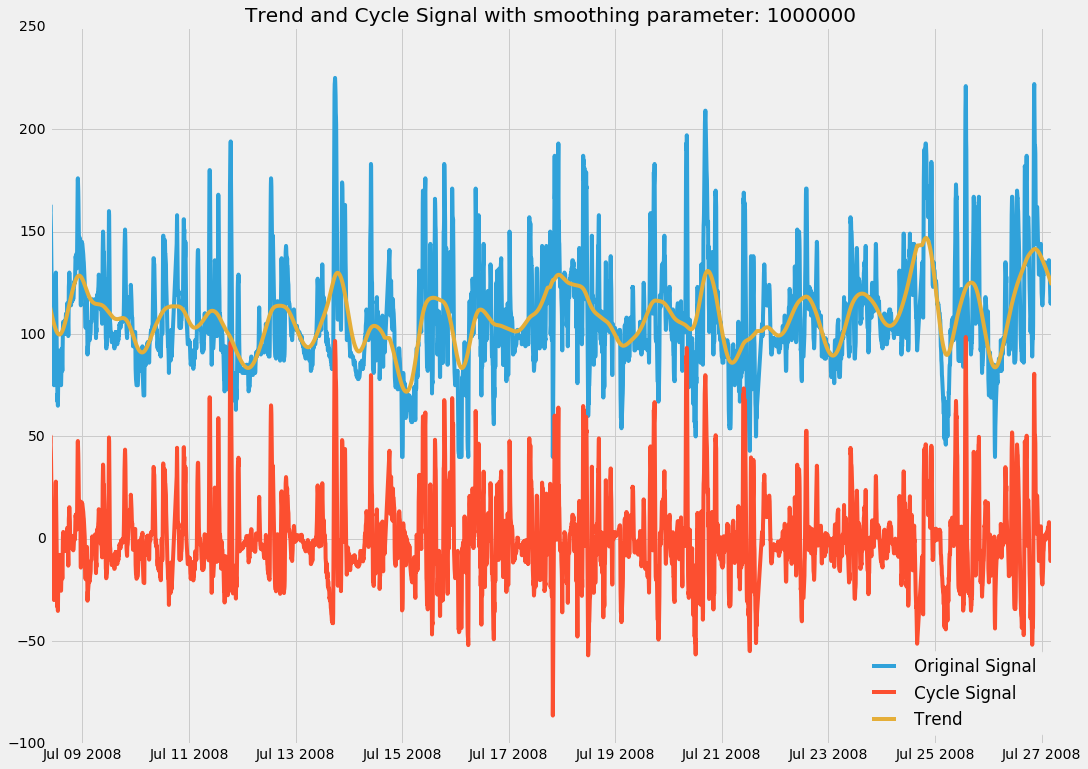

In [31]:
lamb = int(1e6)
snp_cycle, snp_trend = sm.tsa.filters.hpfilter(df['mg/dL'], lamb=lamb)
title = _HODRICK_PRESSCOTT_TITLE_TEMPLATE(lamb)
fig_path = os.path.join(_FIG_DIR, _file_format(title))
plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df.Date, df['mg/dL'], '-', label=_ORIGINAL_SIGNAL_LABEL)
plt.plot_date(df.Date, snp_cycle, '-', label=_SNP_CYCLE_SIGNAL_LABEL)
plt.plot_date(df.Date, snp_trend, '-', label=_SNP_TREND_SIGNAL_LABEL)
plt.title(title)
plt.legend(loc=_FIG_LEGEND_LOCATION);
plt.savefig(fig_path, format=_FIG_FORMAT, dpi=_FIG_DPI)

### Test stationarity

 Test stationarity for cycle: Trend and Cycle Signal with smoothing parameter: 1000000


C:\Users\engadmin\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\engadmin\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


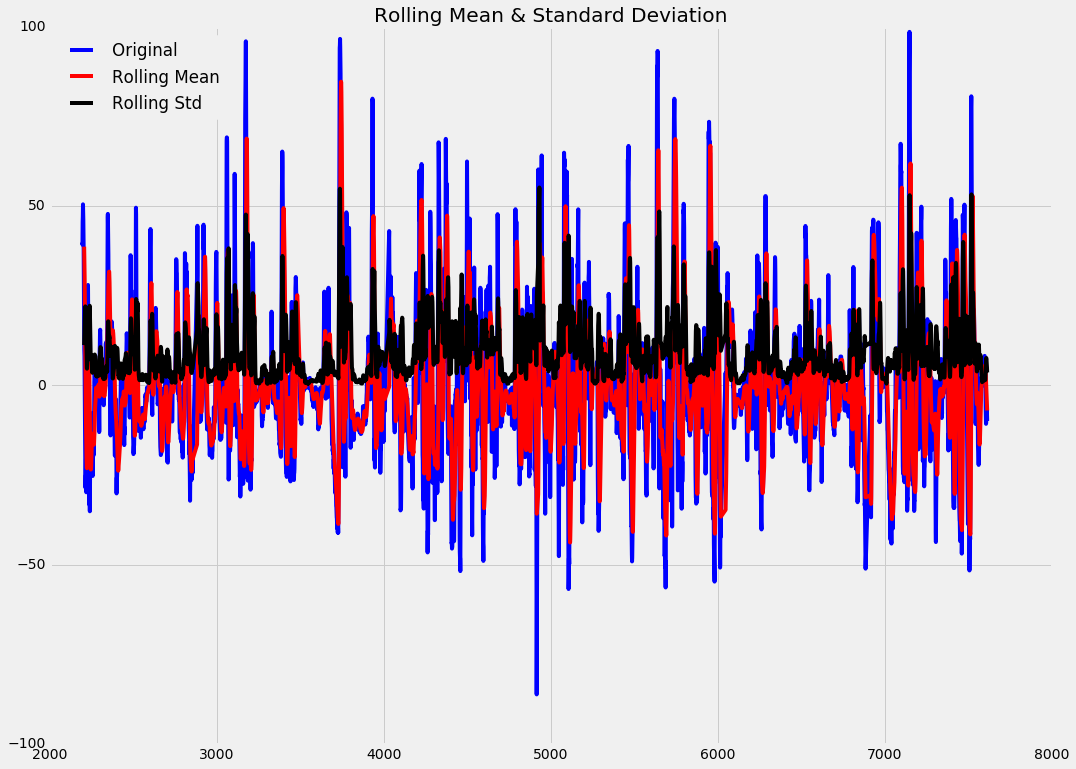

Results of Dickey-Fuller Test:
Test Statistic                -1.699801e+01
p-value                        8.770568e-30
#Lags Used                     1.600000e+01
Number of Observations Used    5.277000e+03
Critical Value (5%)           -2.862088e+00
Critical Value (1%)           -3.431590e+00
Critical Value (10%)          -2.567062e+00
dtype: float64

 95% confidence:
Is the Test Statistic( -16.9980111046 )less than the Critical Value(5%) ( -2.86208786882 ): True
Is the p-value ( 8.77056797978e-30 )less than the 0.05: True
Then...
we reject the null hypothesis and say series is stationary series, since the test statistic < critical values and p-value < 0.05


In [32]:
print" Test stationarity for cycle:" , title

test_stationarity( snp_cycle)
test_stationarity_DickeyFuller( snp_cycle)

 Test stationarity for cycle: Trend and Cycle Signal with smoothing parameter: 1000000


C:\Users\engadmin\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\engadmin\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


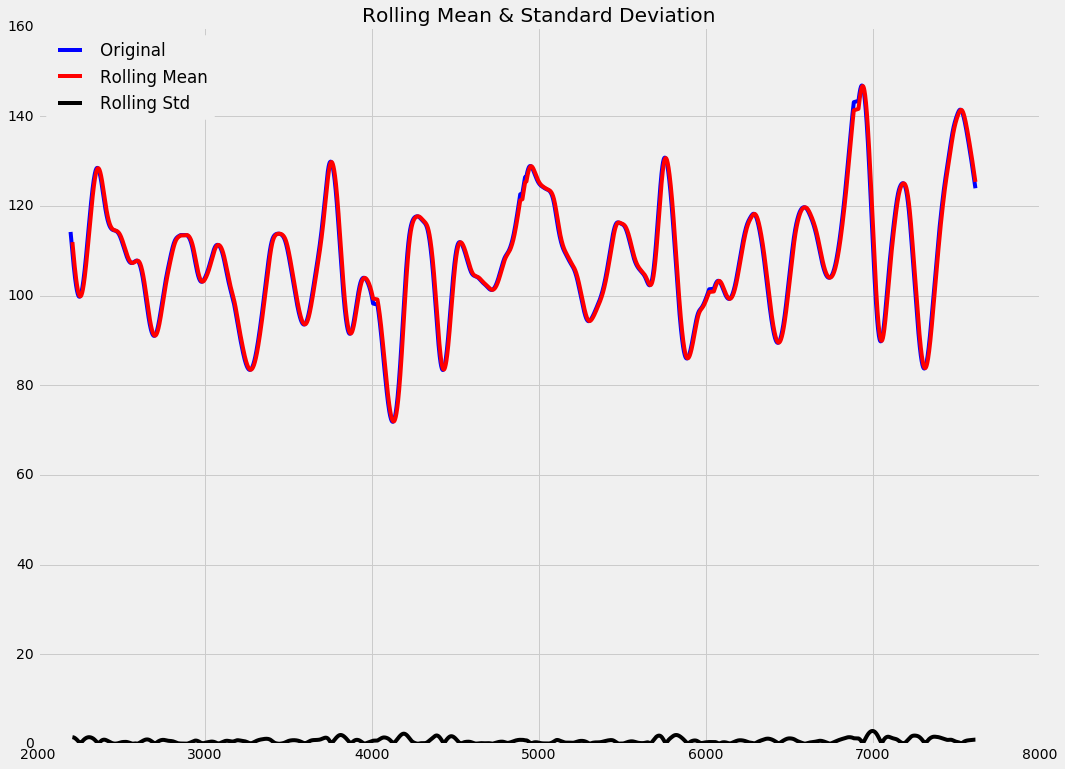

Results of Dickey-Fuller Test:
Test Statistic                   -5.175364
p-value                           0.000010
#Lags Used                       20.000000
Number of Observations Used    5273.000000
Critical Value (5%)              -2.862088
Critical Value (1%)              -3.431591
Critical Value (10%)             -2.567062
dtype: float64

 95% confidence:
Is the Test Statistic( -5.17536358357 )less than the Critical Value(5%) ( -2.86208828454 ): True
Is the p-value ( 9.86952569108e-06 )less than the 0.05: True
Then...
we reject the null hypothesis and say series is stationary series, since the test statistic < critical values and p-value < 0.05


In [33]:
print" Test stationarity for cycle:" , title

test_stationarity( snp_trend)
test_stationarity_DickeyFuller( snp_trend)

# Summary
- If you want to decompose signal into two distinct components, HP Filter is probably one of the best method as long as the recurring cycles exist in the time-series signal.
- If the signal has a lot of noise, median filter much better comparing to other linear methods(EWMA or moving average filter).
- If you want to be able to change your filter based on frequency response of a filter, bandpass filter is the way to go. You could construct various bandstop filters for the frequency ranges that you really do not want to include in the processed signal.